In [1]:
%load_ext autoreload
%autoreload 2

import warnings
# For ignoring warnings printed by R magic commands
warnings.filterwarnings('ignore') 

%load_ext rpy2.ipython

In [2]:
%%R
# ----------------------------------------
# Load R libraries (conda-managed)
# ----------------------------------------
suppressPackageStartupMessages({
  library(ggplot2)
  library(tidyverse)
  library(dplyr)
  library(data.table)
  library(stringr)
  library(glue)

  library(Hmisc)
  library(ggthemes)
  library(gridExtra)
  library(grid)
  library(lattice)
  library(scales)
  library(RColorBrewer)
  library(colorspace)

  library(plotrix)
  library(wesanderson)
  library(ggridges)
  library(ggpattern)
  library(gridpattern)
})


In [3]:
import os
import random

import pandas as pd

# E2E Pareto Plots

## Load Top-Level Dataframes

In [ ]:
# load top-level dataframes
top_level_path = "csv/top-level-dataframes"

iscxvpn2016_df = pd.read_csv(os.path.join(top_level_path, "iscxvpn2016_df.csv"))

## Load E2E Dataframes

In [ ]:
e2e_pareto_path = "csv/e2e-pareto-dataframes"

pareto_iscxvpn2016_df = pd.read_csv(os.path.join(e2e_pareto_path, "pareto_iscxvpn2016_df.csv"))

pareto_iscxvpn2016_df

,name,iterations,f1_score,feature_limit,feature_table_entries,max_depth,num_flows,num_partitions,total_features,tree_table_entries,tcam_entries,memory_bits,memory_perc
0,netbeacon,0,0.780000,0,0,15,65536,0,6,3776,3776.0,37748736.0,30.0
1,netbeacon,0,0.780000,0,0,15,98304,0,6,3776,3776.0,37748736.0,30.0
2,netbeacon,0,0.780000,0,0,15,196608,0,6,3776,3776.0,37748736.0,30.0
3,netbeacon,0,0.740000,0,0,9,262144,0,6,1848,1848.0,75497472.0,60.0
4,netbeacon,0,0.740000,0,0,9,294912,0,6,1848,1848.0,75497472.0,60.0
5,netbeacon,0,0.740000,0,0,9,393216,0,6,1848,1848.0,75497472.0,60.0
6,netbeacon,0,0.570000,0,0,13,491520,0,4,1713,1713.0,62914560.0,50.0
7,netbeacon,0,0.300000,0,0,15,589824,0,3,514,514.0,75497472.0,60.0
8,netbeacon,0,0.300000,0,0,15,688128,0,3,514,514.0,75497472.0,60.0
9,netbeacon,0,0.300000,0,0,15,786432,0,3,514,514.0,75497472.0,60.0


## Pareto Plotting

In [6]:
%%R
create_pareto_plot <- function(
    pareto_df, 
    line_size=1,
    point_size=2,
    x_label="#Flows", 
    y_label="F1 Score",
    y_title=element_blank(),
    tag, 
    x_breaks=c(0, 100000, 500000, 1000000),
    y_breaks,
    y_limits,
    legend_position="none"
    ) {

    blues = brewer.pal(n = 9, "Blues")[5:9]
    reds  = brewer.pal(n = 9, "Reds")[4:8]

    pareto_color_palette <- c(reds[4], reds[1], blues[3])
    new_legend_labels <- c("NB", "Leo", "SpliDT")

    pareto_df$name <- factor(pareto_df$name, levels = c("netbeacon", "leo", "cap"))

    pareto_plot <- ggplot(pareto_df, aes(x=num_flows, y=f1_score, color=name)) +
        geom_line(linewidth = line_size) +
        geom_point(size = point_size) +
        labs(x = x_label, y = y_label, tag = tag) +
        scale_x_continuous(
            breaks = x_breaks,
            labels = label_number(scale_cut = cut_si(""), accuracy = 1)
        ) +
        scale_y_continuous(
            breaks = y_breaks, 
            labels = scales::number_format(accuracy = 0.01)
        ) +
        coord_cartesian(ylim = y_limits) +
        theme_hc(base_size = 22) +
        theme(
            axis.ticks = element_line(color = "black"),
            axis.ticks.length = unit(0.15, "cm"),
            plot.title = element_text(hjust = 0.5),
            axis.text.x = element_text(colour = "black", size = 16),
            axis.text.y = element_text(colour = "black", size = 16),
            axis.title.x = element_text(colour = "black", size = 18),
            axis.title.y = y_title,
            legend.text = element_text(size = 16),
            plot.tag = element_text(
                colour = "black", size = 18, angle = 0,
                margin = margin(t = -10, r = 0, b = 0, l = 0, unit = "pt"),
                vjust = 2.0
            ),
            plot.tag.position = "top"
        ) +
        guides(
            fill = guide_legend(ncol = 1, title = NULL),
            linetype = "none"
        ) +
        theme(
            plot.margin = margin(0.6, 0.25, 0.1, 0.25, "cm"),
            legend.margin = margin(t = -10.5, r = 0, b = 0, l = 0, unit = "pt"),
            legend.key.width = unit(0.4, "lines"),
            legend.key.height = unit(0.4, "lines"),
            legend.spacing.x = unit(0.05, "cm"),
            legend.spacing.y = unit(0.05, "cm"),
            legend.title = element_blank(),
            legend.position = legend_position,
            legend.justification = c(0, 1)
        ) +
        scale_color_manual(values = pareto_color_palette, labels = new_legend_labels)

    return(pareto_plot)
}

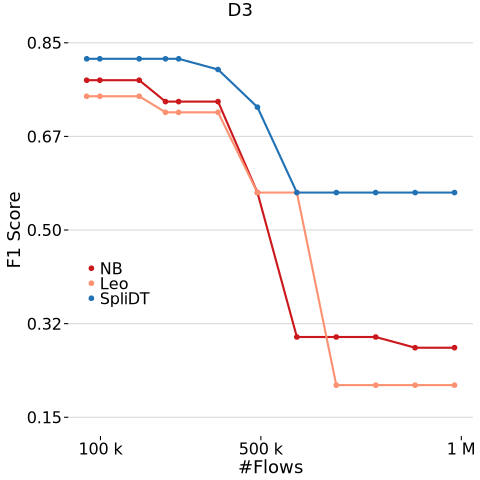

In [7]:
%%R -i pareto_iscxvpn2016_df
pareto_iscxvpn2016_plot <- create_pareto_plot(
    pareto_df=pareto_iscxvpn2016_df, 
    tag="D3", 
    y_title=element_text(colour="black", size=18),
    y_breaks=seq(from=0.15, to=0.85, length.out=5),
    y_limits=c(0.15, 0.85),
    legend_position=c(0.05, 0.4)
)
pareto_iscxvpn2016_plot

In [ ]:
%%R
ggsave(
    pareto_iscxvpn2016_plot, 
    width=5.0, height=2.5, # 18.0, 2.5
    file="generated/artifact-fig6-D3.pdf"
)